In [1]:
    __test__ = dict(
        gold="""
        >>> g = a**str&[str.upper]|a**int&range|a**float&type
        >>> f = a/g*list
        >>> f(['keep it 💯', 10, 10.])
        [['KEEP IT 💯'], range(0, 10), <class 'float'>]
        >>> assert type(copy(g)({})) is Ø""",
        simple=""">>> assert a[range](10) == range(10)
        >>> assert a[range][type](10) is range 
        >>> assert a[range][type][type](10) is type
                
        Begin a composition with a decorator.
        >>> @a.append
        ... def thang(x):
        ...     return range(x)
        >>> assert thang[len](10) is 10""",
        juxt="""
        >>> assert juxt(range)(10) == range(10)
        >>> assert juxt([range])(10) == [range(10)]
        >>> assert juxt([range, type])(10) == [range(10), int]
        >>> assert juxt([range, type, str, 20])(10) == [range(10), int, '10', 20]
                
        >>> assert isinstance(juxt({})(), dict) and isinstance(juxt([])(), list) and isinstance(juxt(tuple())(), tuple)""")

In [2]:
    from dataclasses import dataclass as _dataclass, field
    from itertools import chain
    from functools import partialmethod, wraps
    import sys, operator, inspect
    from collections import Sized, Mapping, Iterable, UserDict
    from toolz import excepts, concat, reduce, groupby
    from copy import copy
    
    from inspect import unwrap, Signature, signature, Parameter, getdoc
    from abc import ABCMeta, ABC, abstractstaticmethod

    dunder = '__{}__'.format
    dataclass = _dataclass(hash=False)
    
    __all__ = 'a', 'an', 'the', 'parallel', 'star', 'do', 'preview', 'x',\
    'op', 'juxt', 'cache', 'store', 'Ø', 'λ', 'identity', 'partial', 'this', 'composite'

    binop = 'add', 'sub', 'mul', 'truediv', 'floordiv', 'mod', 'lshift', 'rshift', 'matmul'
    boolop =  'gt', 'ge', 'le', 'lt', 'eq', 'ne'
    nop = 'abs', 'pos', 'neg', 'pow'
    getters = 'attrgetter', 'itemgetter', 'methodcaller'

In [3]:
    def isiterable(object: object) -> bool: 
        """Is {object} iterable?
        
        >>> assert all(map(isiterable, (list(), dict(), set())))
        >>> assert not any(map(isiterable, (10, range, "strings are not iterable")))
        """
        return isinstance(object, Iterable) and not isinstance(object, str) and not callable(object)

In [4]:
    def identity(*tuple, **dict): 
        """An identity that returns {tuple[0]} if it exists.
        
        >>> assert not identity(**dict(foo=42))
        >>> assert identity(10, 20, dict(foo=42)) is 10
        """
        return tuple[0] if tuple else None

In [5]:
    class partial(__import__('functools').partial):
        """An overloaded {functools.partial}.  It is not recommended to use this partial directly.
        >>> from functools import partial as python_partial
        >>> assert issubclass(partial, python_partial)
        """
        def __new__(partial, func=None, *tuple, **dict):
            """A __new__ {partial} transforms non-callables into callables.
            
            >>> assert partial(range, 10)(20) == range(10, 20)
            >>> assert partial(10)(20) is 10
            
            A partial with no arguments is an identity
            >>> assert partial()(10, 20) is 10"""
            
            if not callable(func): tuple, func = (func,) + tuple if func is not None else tuple, identity
            return                 super().__new__(partial, func, *tuple, **dict)

        def __eq__(partial, object):
            """Supply an __eq__uality condition {partial}
            
            >>> assert partial(range) == partial(range) and partial(range, 10) != partial(range)"""
            return type(partial) is type(object) and partial.func == object.func and partial.args == object.args
        
        def __hash__(partial): 
            """>>> assert hash(partial())"""
            return hash((partial.func, partial.args))
        
        @property
        def __wrapped__(partial):
            """Supply a __wrapped__ Attribute to use inspect.unwrap.
            
            >>> assert unwrap(partial(partial(partial(partial(partial(range)))))) is range"""
            while hasattr(partial, 'func'): partial = getattr(partial, 'func')
            return                          partial
        
        @property
        def __call__(self):
            """Supply __call__ as a property that returns the partial with the signature
            of the wrapped function.
            
            >>> assert signature(partial(identity)) == signature(identity)"""
            @wraps(unwrap(self))
            def signed(*tuple, **dict):
                nonlocal self
                return super(type(self), self).__call__(*tuple, **dict)
            return signed

In [6]:
    class this(partial):
        """this is a partial for MethodType objects.
        
        >>> assert this(str.replace, 'a', 'b')('abc') == 'bbc'"""
        def __call__(this, object): return partial(this.func, object)(*this.args, **this.keywords)

In [7]:
    class do(partial):
        """do calls func, but returns the input arguments.
        
        >>> assert do(range)(10) is 10
        >>> assert do(print)(10)
        10
        """
        def __call__(do, *tuple, **dict): 
            partial(do.func, *do.args, **do.keywords)(*tuple, **dict)
            return identity(*tuple, **dict)

In [8]:
    class star(partial):
        """Apply the callable with star args and keywords.
        >>> assert star(range)((10, 20)) == star(range)([10], {}, [20]) == range(*(10, 20))
        """
        def __call__(star, *object): 
            args, dict = star.args, star.keywords
            for next in object:
                if isinstance(next, Mapping): dict = {**dict, **next}
                if isiterable(object):        args += tuple(next)
            return partial(star.func)(*args, **dict)

In [9]:
    class Ø(BaseException): 
        """An Inner callable may return a Ø Exception."""
        def __bool__(x): return False
        def __invert__(x): return True

In [10]:
    @dataclass
    class composable:
        object: tuple = field(default_factory=tuple)   
        def __post_init__(composable):
            
            if composable.object is None:                 composable.object = tuple()
            if not isinstance(composable.object, tuple):  composable.object = tuple([composable.object])
            
        def __iter__(composable):
            if isiterable(composable.object): yield from composable.object
            else:                             yield composable.object
        
        def __bool__(composable): return bool(len(composable))        
        
        def __len__(composable):  return isinstance(composable.object, Sized) and len(composable.object) or 0
        
        def __hash__(composable): return hash(map(hash, composable))

        def append(self=Ø(), object=Ø()):
            if object is getdoc:           return self
            
            if isinstance(self, type) and \
            issubclass(self, composable):  self = self()
            
            if not isinstance(object, Ø):  self.object = type(self.object)(chain(self.object, [object]))
                
            return self

        def __getstate__(composable):
            return tuple(getattr(composable, slot, None) for slot in composable.__dataclass_fields__)
        
        def __setstate__(composable, tuple):
            list(setattr(composable, str, object) for str, object in zip(composable.__dataclass_fields__, tuple)) 
            return composable
        
        @property
        def __name__(composable): return type(composable).__name__
        
        __signature__ = inspect.signature(identity)
        
        def __call__(composable, *tuple, **dict): 
            for callable in composable: 
                tuple, dict = (partial(callable)(*tuple, **dict),), {}
            return partial(identity)(*tuple, **dict)
        
        def __getitem__(composable, object):
            """Slice the composites or append callables."""
            if isinstance(object, (int, slice)):
                return composable.object[object]
            return composable.append(object)        

In [11]:
    class juxt(composable):
        def __iter__(juxt):
            if isinstance(juxt.object, Mapping):
                yield from map(type(juxt), juxt.object.items())
            else:
                yield from super().__iter__()

        def __call__(juxt, *tuple, **dict):
            if not isiterable(juxt.object): 
                return juxt.object(*tuple, **dict)
            return (type(juxt.object) if isinstance(juxt.object, Sized) else identity)(
                    partial(callable)(*tuple, **dict) for callable in juxt)
        
        def __post_init__(juxt): ...

In [12]:
    class interpolate(composable):
        def __iter__(interpolate):
            yield from map(juxt, super().__iter__())

In [13]:
    class logic(juxt):                        
        """
        >>> assert logic(bool)(10)
        >>> assert isinstance(logic(bool)(0), Ø)
        >>> assert isinstance(logic((bool, int))(0), Ø)
        >>> assert logic((bool, int))(10) == (True, 10)
        """
        def __post_init__(logic):
            if isinstance(logic.object, type) and logic.object is not bool:
                logic.object = this(isinstance, logic.object)
            super().__post_init__()
            
        def __iter__(logic): 
            yield from super().__iter__() or (True,)
        
        def __call__(logic, *tuple, **dict):
            object = super().__call__(*tuple, **dict)
            if not isiterable(logic.object): 
                return object or Ø(logic.object)
            
            for next in object:
                if next: continue
                return Ø(logic.object)
            
            return object or True

In [14]:
    class Composite(interpolate, metaclass=ABCMeta):
        @abstractstaticmethod
        def __callable__(Composite):
            raise NotImplemented("""A Composite must define a __callable__ operation.""")

    @dataclass
    class composite(Composite):
        """Pose a functional composite with Inner and Outer callable. The Outer callable may accept exceptions. 
        Pose is combined with the prefixes Pro, Ex, Im, and Juxt to evaluate inner call methods. 
        """
        predicate: logic = field(default_factory=logic)
        object: interpolate = field(default_factory=interpolate)    
        exception: tuple = field(default_factory=tuple)
        
        @staticmethod
        def __callable__(predicate, object, *tuple, **dict):
            """require the predicate to be true before evaluating the object"""
            predicate = predicate(*tuple, **dict)
            if object and predicate: 
                return partial(object)(*tuple, **dict)
            return predicate and True   
            
        def __post_init__(composite):
            if not isinstance(composite.predicate, logic): 
                composite.predicate = logic(composite.predicate)
            if not isinstance(composite.object, interpolate): 
                composite.object = interpolate(composite.object)
                        
        def append(composite, object):
            composite.object = composite.object.append(object)
            return composite
        
        def __iter__(composite, *tuple, **dict):
            yield from (composite.predicate, composite.object)
            
        @property
        def __call__(composite): 
            @wraps(composite)
            def signed(*args, **dict):
                try:
                    return partial(composite.__callable__, *iter(composite))(*args, **dict)
                except composite.exception or tuple() as Exception:
                    return Ø(Exception)
            try:
                signed.__signature__  = signature(composite.object[0])
            except: 
                assert True, "The first callable has no signature."
                signed.__signature__ = Signature(Parameter(f'_{i}', Parameter.POSITIONAL_OR_KEYWORD) for i in range(10))
            return signed

In [15]:
    class pipe(composite):
        @staticmethod
        def __callable__(predicate, object, *tuple, **dict):
            """pipe a ~Ø predicate """
            predicate = predicate(*tuple, **dict)
            if predicate is True: 
                predicate = identity(*tuple, **dict)
            return predicate and partial(object)(predicate)

In [16]:
    class conjugate(composite):
        @staticmethod
        def __callable__(predicate, object, *tuple, Exception=None, **dict):
            return predicate(*tuple, **dict) or partial(object)(*tuple, **dict)

In [17]:
    class conditions:
        def __pow__(x, object):
            object = this(isinstance, object)
            return compose(predicate=object, object=(x.append(Ø()),))
        
        def __and__(x, object): 
            return ifthen(predicate=x.append(Ø()), object=object)
        
        def __or__(x, object):  
            return ifnot(predicate=x.append(Ø()), object=object)
        
        def __xor__(x, object): 
            return setattr(x.append(Ø()), 'exception', object) or x
        
        then = __and__
        ifnot = __or__
        instance = ifthen = __pow__
        excepts = __xor__

In [18]:
    class symbols:
        """Operations that operator on containers.

        >>> assert a@range == a.groupby(range)
        >>> assert a/range == a.map(range)
        >>> assert a//range == a.filter(range)
        >>> assert a%range == a.reduce(range)
        >>> assert copy(a%range) == a.reduce(range)
        """        
        def _left(x, callable, object=None, partial=this):
            return x.append(callable if object is None else partial(callable, object))    

        def _right(right, attr, left):
            return getattr(symbols._left(compose(), left), dunder(attr))(right)            

        __truediv__ = map = partialmethod(_left, map, partial=partial)
        __floordiv__ = filter = partialmethod(_left, filter, partial=partial)
        __mod__ = reduce = partialmethod(_left, reduce, partial=partial)
        __matmul__ = groupby =  partialmethod(_left, groupby, partial=partial)

        @property
        def __mul__(symbols): return symbols.append
        __add__ = __sub__ = __rshift__= __mul__
        
        def __lshift__(x, object): return x.append(do(object))
        do = __lshift__

    list(setattr(symbols, '__r' + dunder(attr).lstrip('__'), partialmethod(symbols._right, attr))
         for attr in binop);

In [19]:
    class __getattr__:
        def __init__(__getattr__, parent=None, object=None):
            __getattr__.parent = composite() if parent is None else parent
            __getattr__.object = object or tuple()
            
        def __getattr__(x, str):
            if str.startswith('_repr'): raise AttributeError(str)
                
            object = x.object
            if object:
                object += getattr(object[-1], str),
            else:
                for module in map(__import__, attributes.shortcuts):
                    if hasattr(module, str): 
                        object += getattr(module, str),
                        break
                else:
                    try:
                        object += __import__(str),
                    except ModuleNotFoundError:
                        raise AttributeError(next)                
            return __getattr__(parent=x.parent, object=object) 

        @property
        def __call__(x):
            *parent, object = x.object
            @wraps(object)
            def signed(*tuple, **dict):
                nonlocal object, parent, x
                for decorate, set in attributes.decorators.items():
                    if object in set: 
                        object = decorate(object)
                        break
                else:
                    object = partial(this if parent and isinstance(parent[-1], type) else partial, object)
                object = object(*tuple, **dict)
                if not (object.args or object.keywords):
                    object = object.func
                return x.parent.append(object)
            return signed

        @property
        def __wrapped__(x): 
            *parent, object = x.object
            return unwrap(object)
        
        def __repr__(x): return repr(unwrap(x))
        
        def __dir__(x):
            if x.object: return dir(x.object[-1])
            return super().__dir__() + (
                list(object for object in __import__('sys').modules if not '.' in object) 
                + list(concat(dir(__import__(module)) for module in attributes.shortcuts)))

In [20]:
    class attributes:
        """
        >>> assert not any(x in dir(x) for x in sys.modules if not '.' in x)
        >>> assert all(x in dir(a) for x in sys.modules if not '.' in x)
        """
        shortcuts = 'statistics', 'toolz', 'requests', 'builtins','json', 'pickle', 'io', 'collections', \
        'itertools', 'functools', 'pathlib', 'importlib', 'inspect', 'operator'
        decorators = dict()
        
        def __getattr__(x, attr):
            """Access attributes from sys.modules or x.shortcuts"""
            return __getattr__(parent=x).__getattr__(attr)
        
        def __dir__(x): return dir(__getattr__(parent=x))

    attributes.decorators[identity] = operator.attrgetter(*getters)(operator)
    attributes.decorators[partial(partial, this)] = [object for object in vars(operator).values() 
     if object not in attributes.decorators[identity]] + [__import__('fnmatch').fnmatch]

In [21]:
    class composition(attributes, symbols, conditions): 
        """Composition methods for establishing Positions using __magic__ Python methods.
        """
    class compose(composite, composition):
        """Evaluate the outer callable if the inner callable is ~Ø."""
    class ifthen(pipe, composition): 
        """Pass ~Ø inner function return values as input to the outer function."""
    class ifnot(conjugate, composition): 
        """Evaluate the other outer function is the inner function is Ø."""        

In [22]:
    class factory: 
        args = keywords = None
        def append(factory, object=Ø()):
            tuple, dict = getattr(factory, 'args', []), getattr(factory, 'keywords', {})
            return super().__call__().append(
                partial(object, *tuple, **dict) if tuple or dict else object)
        
        def __call__(factory, *tuple, **dict):
            args, kwargs = getattr(factory, 'args', []), getattr(factory, 'keywords', {})
            if args or kwargs:
                return partial(identity)(*args, *tuple, **kwargs)
            return super().__call__(*tuple, **dict)
        
        def __bool__(factory): return False
        
        __getitem__ = append

In [23]:
    @_dataclass
    class curry(factory, composition, interpolate):
        args: tuple = field(default_factory=tuple, init=False)
        keywords: dict = field(default_factory=dict, init=False)

        def __call__(curry, *tuple, **dict): 
            if tuple or dict:
                curry = copy(curry)
                curry.args, curry.keywords = tuple, dict
                return curry
            return super().__call__(*tuple, **dict)

In [24]:
    a = an = the = then = λ = curry(object=compose)

In [25]:
    @_dataclass
    class canonical(compose):
        __annotations__ = {}
        args = keywords = None
        def __post_init__(x, *args, **kwargs): 
            super().__post_init__(*args, **kwargs)
            
        def _left_(x, callable, arg=None, partial=this):
            if callable is getattr and isinstance(arg, str) and arg.startswith('_ipython'):
                return x
            return x.append(partial(callable, arg))

        def _right_(x, callable, left):
            return canonical._left_(x, callable, left, partial=partial)

        def _bool_(x, callable, *args):
            return ifthen(predicate=x.append(this(callable, *args)))
        
        def __getattr__(x, object):
            if object == '__qualname__': return canonical.__qualname__
            if object not in ('func', '__wrapped__'):
                return canonical._left_(x, getattr, object)
            raise AttributeError(object)
        
    for attr in binop + ('getitem',):
        op, rop =  getattr(operator, attr), '__r' + dunder(attr).lstrip('__')
        setattr(canonical, dunder(attr), partialmethod(canonical._left_, op))
        setattr(canonical, rop, partialmethod(canonical._right_, op))        
        
    list(setattr(canonical, dunder(attr), partialmethod(canonical._bool_, getattr(operator, attr)))
         for attr in boolop)
    list(setattr(canonical, dunder(attr), partialmethod(canonical._left_, getattr(operator, attr)))
         for attr in nop);

In [26]:
    class operate(factory, canonical): 
        """
        >>> f = (0<x)&(x<10)*(x+90)
        >>> assert all(map(a**Ø, (f(-5), f(15))))
        >>> assert f(5) is 95"""
    x = op = operate(object=canonical)

In [27]:
    class preview(compose):
        def __repr__(x): return repr(x())
        
    pre = preview = curry(object=preview)

In [28]:
    @dataclass
    class parallel(compose):
        """An embarassingly parallel proposition; call the outer function in parallel in the inner function is ~Ø.
        
        >>> import joblib
        >>> def g(x): return x+10
        >>> assert parallel(jobs=4).range().map(x+10)(100)
        >>> assert parallel(jobs=4).range().map(a[range])(100)
        """
        
        jobs: int = field(default=4)
        def map(x, object): return super().map(__import__('joblib').delayed(object))

        def __call__(x, *tuple, **dict):
            return __import__('joblib').Parallel(x.jobs)(super().__call__(*tuple, **dict))

        __truediv__ = map

In [29]:
    @_dataclass(repr=False)
    class store(UserDict):
        """
        >>> s = store(range)
        >>> assert 10 not in s and s(10) and 10 in s
        """
        callable: object = field(default_factory=compose)
        __post_init__ = UserDict.__init__
        @property
        def __self__(x): return x.__call__.__self__
        def __call__(x, *tuple, **dict):
            x[tuple[0]] = x.callable(*tuple, **dict)
            return x[tuple[0]]
        def __repr__(x): return str(x.data.keys())

In [30]:
    class cache(store):
        def __call__(x, *tuple, **dict):
            if tuple[0] not in x: 
                return super().__call__(*tuple, **dict)
            return x[tuple[0]]

[NbConvertApp] Converting notebook poser.ipynb to python
[NbConvertApp] Writing 21164 bytes to poser.py
wrote poser.html
parsing /Users/tonyfast/composites/poser.py...
============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/tonyfast/composites, inifile:
plugins: smartcov-0.3, ipynb-1.1.0, hypothesis-3.44.6
collected 21 items                                                              

test_poser.ipynb .....................

========================== 21 passed in 2.09 seconds ===========================


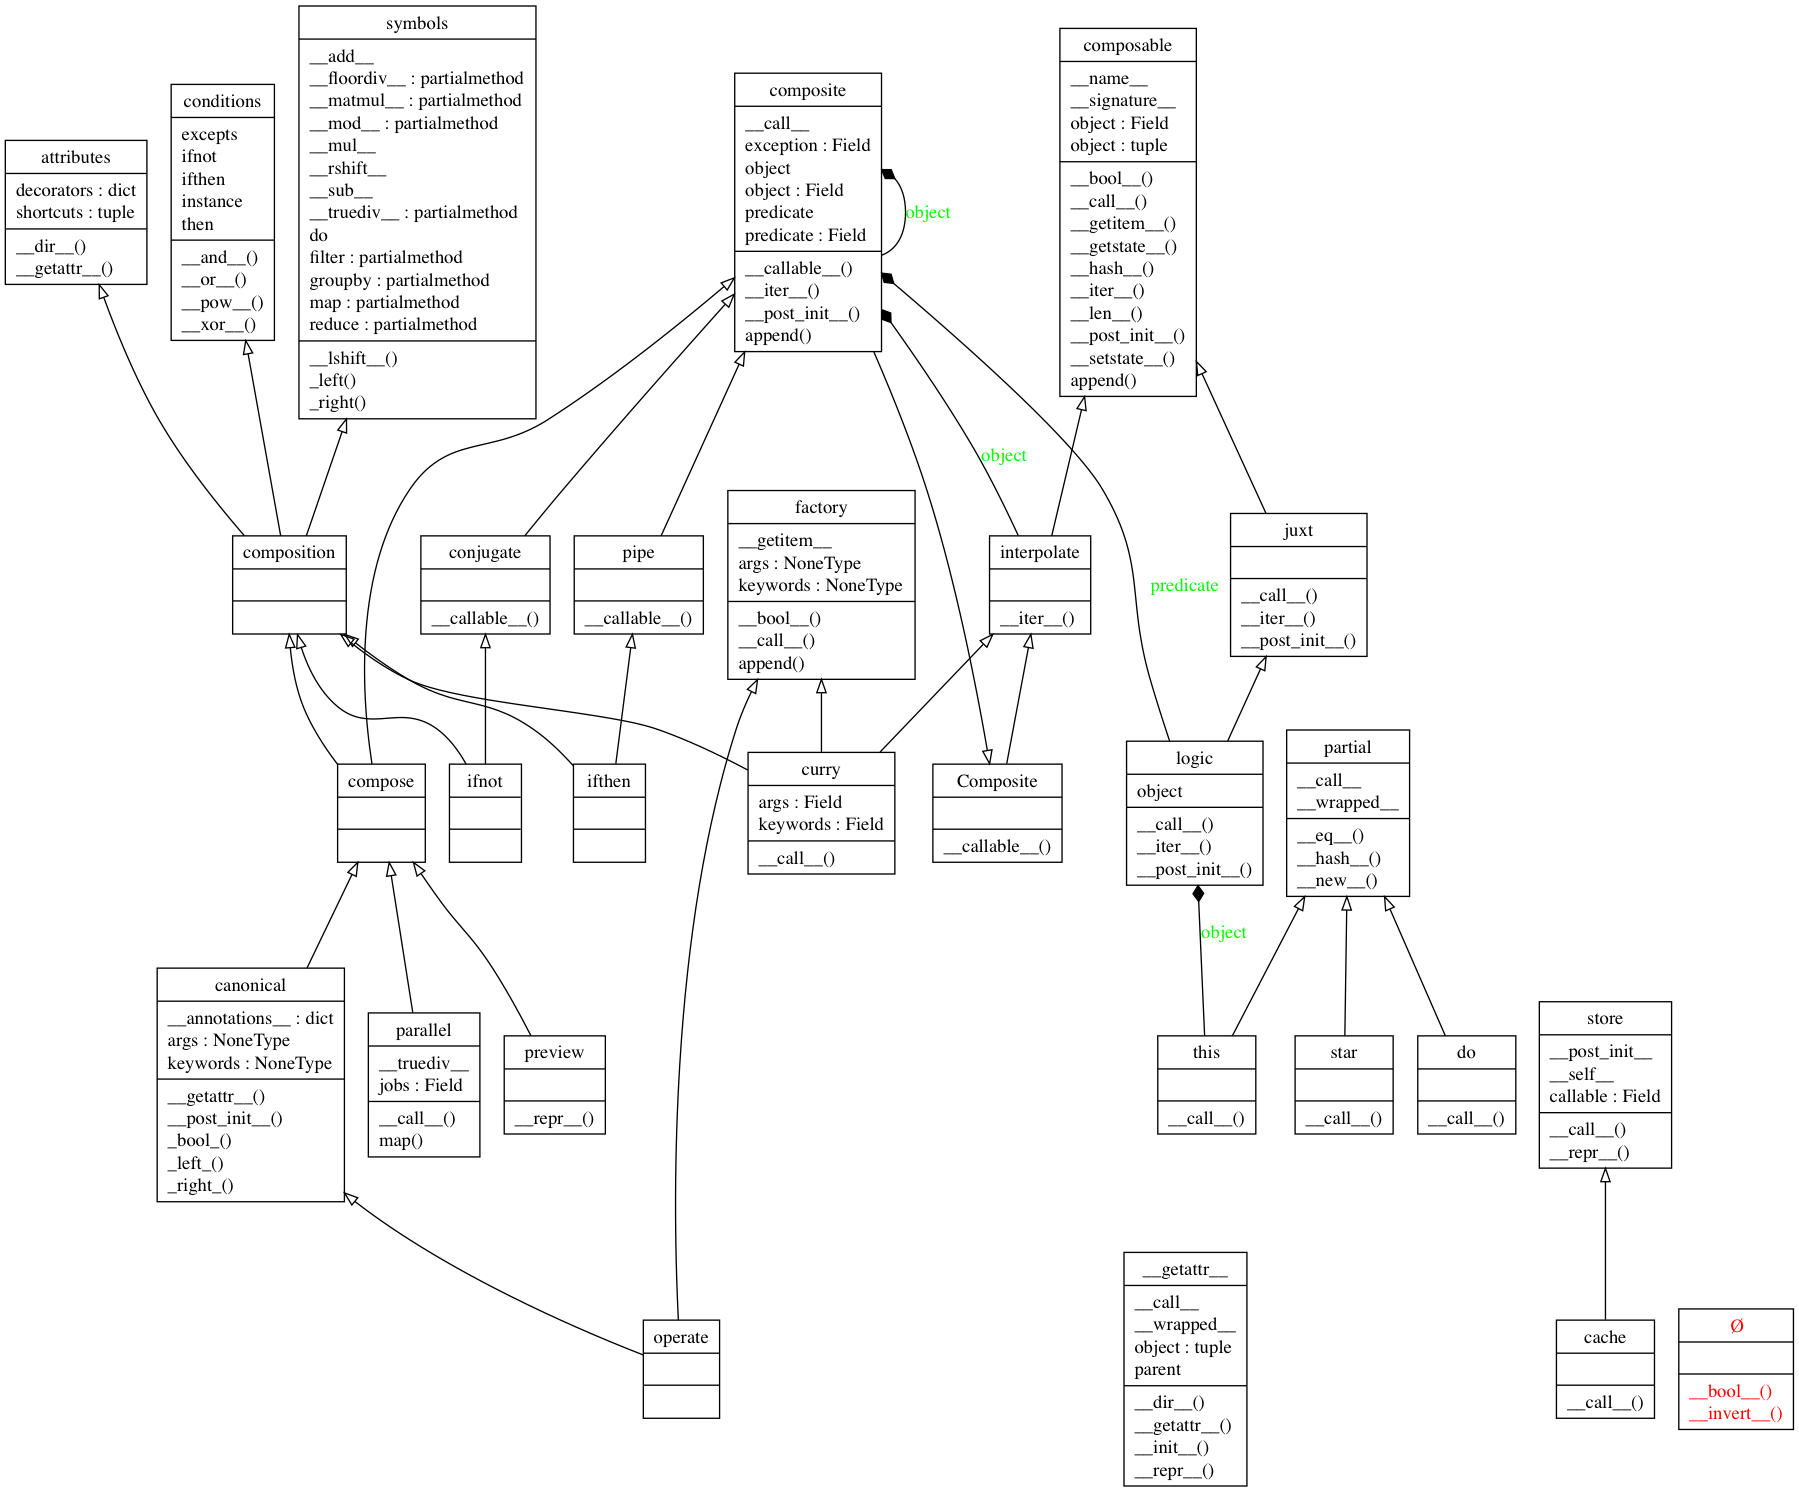

In [31]:
    if __name__ == '__main__':
        if 'runtime' in sys.argv[-1]:
            from IPython import get_ipython, display
            __import__('doctest').testmod()
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True poser.ipynb
            !source activate p6 && python -m pydoc -w poser
            !source activate p6 && pyreverse -o png -pposer -fALL poser
            !source activate p6 && pytest test_poser.ipynb --doctest-modules
            display.display(display.Image('classes_poser.png'), display.IFrame('poser.html', height=600, width=800))
        else:
            print('run from cli')